### Setting up the environment

In [1]:
import tensorflow as tf
import cv2
import imghdr
import os

In [2]:
import matplotlib.pyplot as plt

In [3]:
data_dir = 'data'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [4]:
img =cv2.imread(os.path.join(data_dir, 'Doctor-Prescription_Images', '11042_2020_10151_Fig2_HTML.png'))

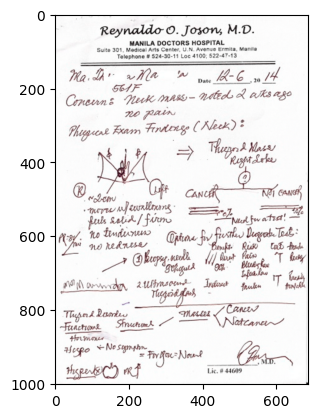

In [5]:
plt.imshow(img)

In [6]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img =cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
                print('Issue with image {}'.format(image_path))

In [7]:
import numpy as np

In [37]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 199 files belonging to 2 classes.


In [9]:
data_iterator = data.as_numpy_iterator()

In [10]:
batch = data_iterator.next()

In [11]:
# Class 1 = doctor-prescription 
# Class 0 = random images
batch[1]

array([1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0])

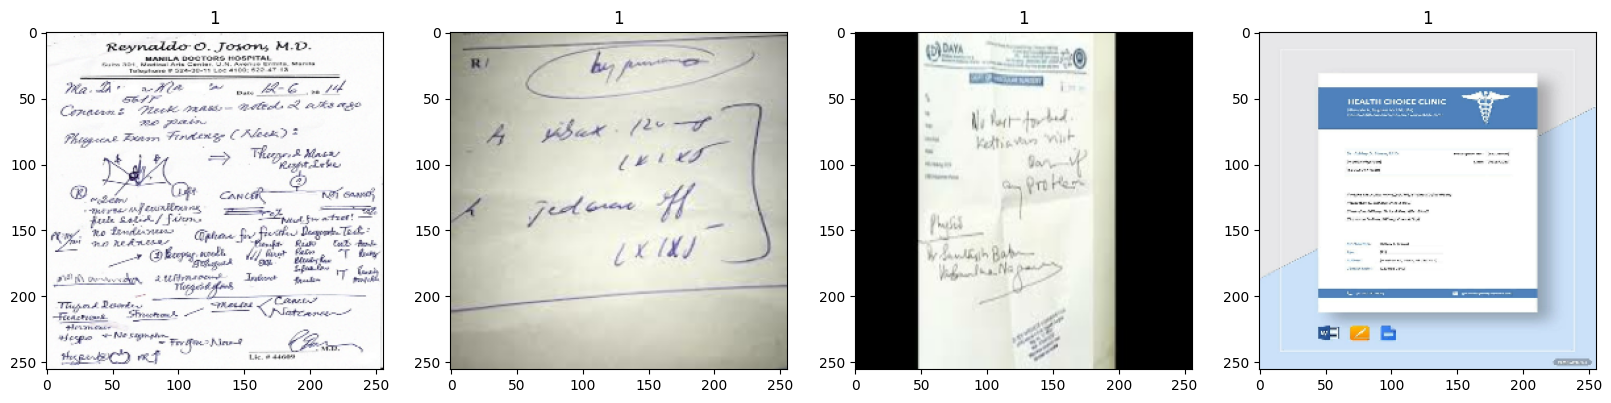

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Scaling the Image


In [13]:
data = data.map(lambda x,y: (x/255, y))

In [14]:
scaled_batch = data.as_numpy_iterator().next()

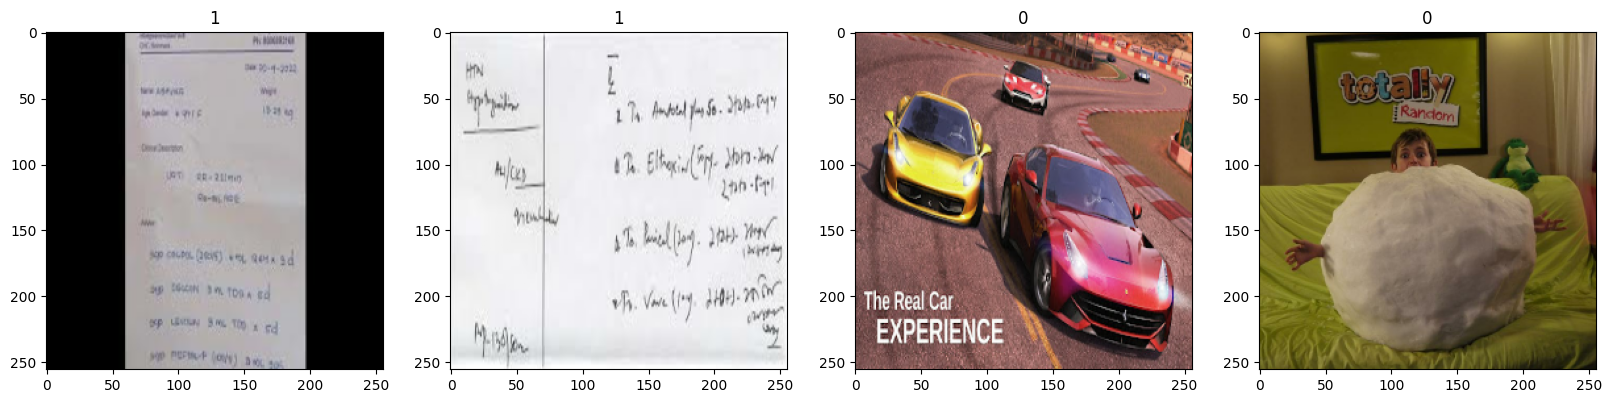

In [53]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(scaled_batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(scaled_batch[1][idx])

In [16]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Training the model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [19]:
model = Sequential()

In [20]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [23]:
logdir='logs'

In [24]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [25]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 13s 3s/step - loss: 0.9738 - accuracy: 0.6172 - val_loss: 0.5705 - val_accuracy: 0.6875
Epoch 2/20
4/4 [==============================] - 8s 2s/step - loss: 0.4943 - accuracy: 0.7500 - val_loss: 0.2533 - val_accuracy: 0.9688
Epoch 3/20
4/4 [==============================] - 7s 2s/step - loss: 0.2518 - accuracy: 0.9453 - val_loss: 0.2040 - val_accuracy: 0.9531
Epoch 4/20
4/4 [==============================] - 7s 2s/step - loss: 0.2380 - accuracy: 0.9297 - val_loss: 0.2897 - val_accuracy: 0.8750
Epoch 5/20
4/4 [==============================] - 8s 2s/step - loss: 0.2079 - accuracy: 0.9297 - val_loss: 0.2340 - val_accuracy: 0.9219
Epoch 6/20
4/4 [==============================] - 9s 2s/step - loss: 0.1370 - accuracy: 0.9609 - val_loss: 0.1197 - val_accuracy: 0.9688
Epoch 7/20
4/4 [==============================] - 8s 2s/step - loss: 0.1563 - accuracy: 0.9531 - val_loss: 0.1377 - val_accuracy: 0.9688
Epoch 8/20
4/4 [========================

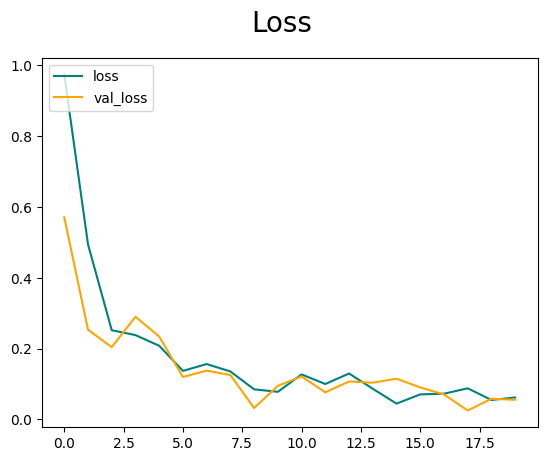

In [26]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

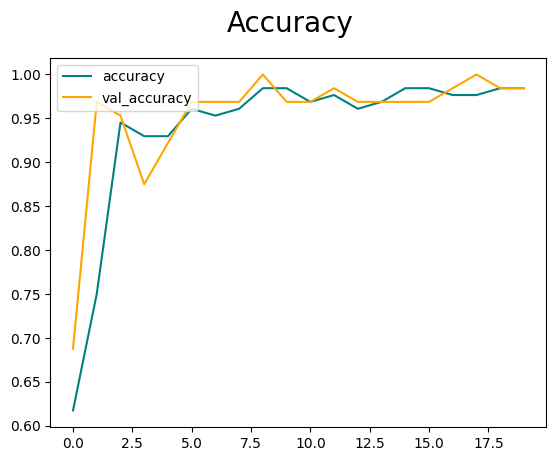

In [27]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Evaluation of model

In [28]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [29]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [30]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 345ms/step


In [31]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


### Test

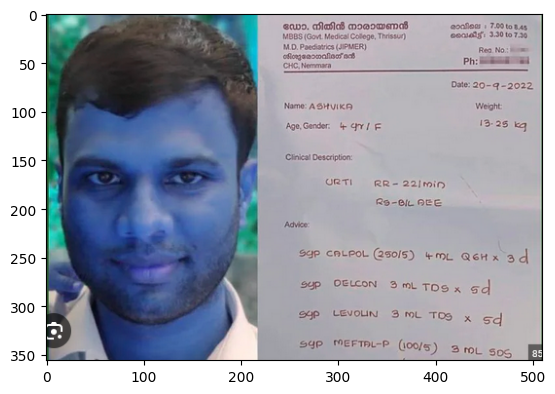

In [45]:
img = cv2.imread('Prescription_Image_2.png')
plt.imshow(img)
plt.show()

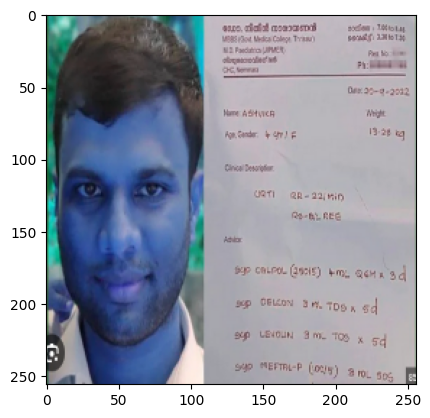

In [46]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [47]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 251ms/step


In [48]:
yhat

array([[0.8149602]], dtype=float32)

In [51]:
if yhat > 0.85: 
    print(f'Predicted class is Doctor Prescription')
else:
    print(f'Predicted class is not a Doctor prescription')

Predicted class is Doctor Prescription


### Save the model

In [52]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models','precriptionClassifier.h5'))